In [9]:
%pip install torch
%pip install torchvision
%pip install -U scikit-learn scipy matplotlib
%pip install tqdm

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


  Obtaining dependency information for tqdm from https://files.pythonhosted.org/packages/00/e5/f12a80907d0884e6dff9c16d0c0114d81b8cd07dc3ae54c5e962cc83037e/tqdm-4.66.1-py3-none-any.whl.metadata
     ---------------------------------------- 0.0/57.6 kB ? eta -:--:--
     ------- -------------------------------- 10.2/57.6 kB ? eta -:--:--
     --------------------------- ---------- 41.0/57.6 kB 393.8 kB/s eta 0:00:01
     -------------------------------------- 57.6/57.6 kB 378.9 kB/s eta 0:00:00
   ---------------------------------------- 0.0/78.3 kB ? eta -:--:--
   ------------------------------------ --- 71.7/78.3 kB 2.0 MB/s eta 0:00:01
   ---------------------------------------- 78.3/78.3 kB 1.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
from torchvision.io import read_image
from pathlib import Path
import torchvision.models as models
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import pickle as pk

In [2]:
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [3]:
# Constants / Macros
batch_size = 64
num_channels = 3 # (r, g, b)
num_classes = 4
num_samples_per_class = 73
SIZE = 224
m, n = SIZE, SIZE
classes = [str(c) for c in range(num_classes)]

ROOT_PATH = '../'

TRAIN_PATH = ROOT_PATH + 'train/'
TEST_PATH = ROOT_PATH + 'test'

In [13]:
os.listdir(TRAIN_PATH)

['0', '1', '2', '3']

In [4]:
torch.cuda.is_available()

False

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
torch.manual_seed(69420)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.11030937731266022, 0.11030937731266022, 0.11030937731266022], \
                         std=[0.18150997161865234, 0.18150997161865234, 0.18150997161865234])
])

In [7]:
train_dataset = datasets.ImageFolder(root=TRAIN_PATH, transform=transform)
test_dataset = datasets.ImageFolder(root=TEST_PATH, transform=transform)
train_dataset, test_dataset

(Dataset ImageFolder
     Number of datapoints: 292
     Root location: ../train/
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
                ToTensor()
                Normalize(mean=[0.11030937731266022, 0.11030937731266022, 0.11030937731266022], std=[0.18150997161865234, 0.18150997161865234, 0.18150997161865234])
            ),
 Dataset ImageFolder
     Number of datapoints: 49
     Root location: ../test
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
                ToTensor()
                Normalize(mean=[0.11030937731266022, 0.11030937731266022, 0.11030937731266022], std=[0.18150997161865234, 0.18150997161865234, 0.18150997161865234])
            ))

In [8]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [9]:
# Model hyperparams
lr = 0.001
momentum = 0.95

In [10]:
# Evaluate with ResNet
torch.manual_seed(69420)

model = models.resnet18()
num_classes = 4  # Number of classes
model.fc = nn.Linear(model.fc.in_features, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

In [11]:
train_loss, train_acc, test_loss, test_acc = [], [], [], []

model.to(device)

print("Start training")
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
      images, labels = images.to(device), labels.to(device)
      optimizer.zero_grad()
      outputs = model(images)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()

    training_loss = running_loss / len(train_loader)
    print(f'Epoch {epoch + 1}, Loss: {training_loss}', end='  |  ')
    train_loss.append(training_loss)

    model.eval()

    correct = 0
    total = 0
    with torch.no_grad():
      for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Train Accuracy: {accuracy:.2f}%', end='  |  ')
    train_acc.append(accuracy)

    correct = 0
    total = 0
    running_testing_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_testing_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')
    test_acc.append(accuracy)
    test_loss.append(running_testing_loss)

torch.save(model.state_dict(), 'resnet18_e20_normalized_from_scratch.ckpt')

Start training
Epoch 1, Loss: 1.4012846946716309  |  Train Accuracy: 27.74%  |  Test Accuracy: 24.49%
Epoch 2, Loss: 1.3720795154571532  |  Train Accuracy: 25.34%  |  Test Accuracy: 22.45%
Epoch 3, Loss: 1.382616138458252  |  Train Accuracy: 25.00%  |  Test Accuracy: 22.45%
Epoch 4, Loss: 1.348340678215027  |  Train Accuracy: 28.42%  |  Test Accuracy: 18.37%
Epoch 5, Loss: 1.3420373439788817  |  Train Accuracy: 27.05%  |  Test Accuracy: 18.37%
Epoch 6, Loss: 1.3183213233947755  |  Train Accuracy: 31.16%  |  Test Accuracy: 24.49%
Epoch 7, Loss: 1.2976136445999145  |  Train Accuracy: 37.33%  |  Test Accuracy: 26.53%
Epoch 8, Loss: 1.2835829973220825  |  Train Accuracy: 46.23%  |  Test Accuracy: 30.61%
Epoch 9, Loss: 1.248461651802063  |  Train Accuracy: 42.81%  |  Test Accuracy: 32.65%
Epoch 10, Loss: 1.226651906967163  |  Train Accuracy: 54.11%  |  Test Accuracy: 38.78%
Epoch 11, Loss: 1.2020267724990845  |  Train Accuracy: 42.81%  |  Test Accuracy: 44.90%
Epoch 12, Loss: 1.167291593551

In [38]:
test_acc[-1]

44.89795918367347

In [ ]:
# Evaluate with ResNet
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
# model = models.resnet18(pretrained=True)
num_classes = 4  # Number of categories
model.fc = nn.Linear(model.fc.in_features, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

In [39]:
output = {"train_losses" : train_loss, "train_accs" : train_acc, 
                        "test_losses" : test_loss, "test_accs" : test_acc}

fname = "ResNet18_Normalized_From_Scratch_Correctly.pkl"

with open(fname, 'wb') as outfile:
    pk.dump(output, outfile)

In [156]:
fname = "ResNet_Baseline_pretrained.pkl"

with open(fname, 'rb') as outfile:
    output = pk.load(outfile)

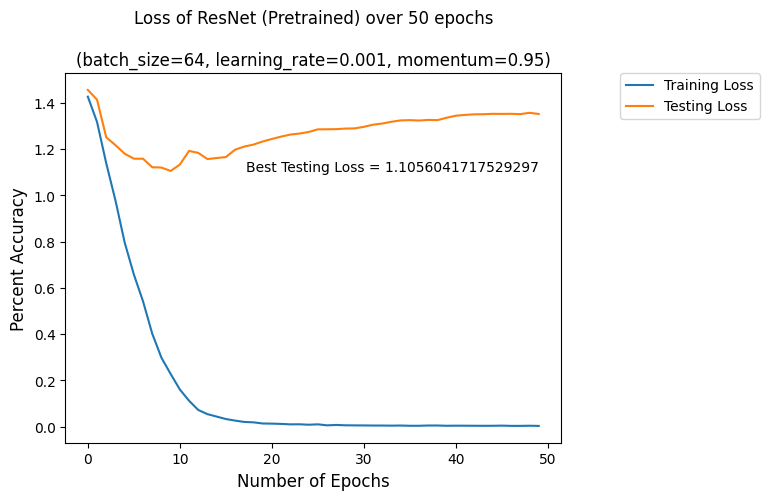

In [168]:
# plot_param = "Accuracy"
plot_param = "Loss"
model_type = "ResNet"

epochs = [i for i in range(num_epochs)]

# with open(fname, 'rb') as f: 
#     output = pk.load(f)

hyperparams = f"(batch_size={batch_size}, learning_rate={lr}, momentum={momentum})"

plt.figure()

# plt.title(f"Accuracy of {model_type} (Pretrained) over 50 epochs\n\n" + hyperparams)
# plt.plot(epochs, output["train_accs"], label = "Training Accuracy")
# plt.plot(epochs, output["test_accs"], label = "Testing Accuracy")


plt.title(f"Loss of {model_type} (Pretrained) over 50 epochs\n\n" + hyperparams)
plt.plot(epochs, output["train_losses"], label = "Training Loss")
plt.plot(epochs, output["test_losses"], label = "Testing Loss")


plt.ylabel("Percent Accuracy", size=12)
plt.xlabel("Number of Epochs", size=12)
plt.legend(bbox_to_anchor=(1.4, 1), loc='upper right', borderaxespad=0)
final_dp = min(output["test_losses"])
plt.text(epochs[-1], final_dp, f"Best Testing {plot_param} = {final_dp}",horizontalalignment='right')
plt.show()

In [79]:
%pip install alexnet_pytorch

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [80]:
# Evaluate with AlexNet
# model = models.alexnet(weights=torchvision.models.AlexNet_Weights)
from alexnet_pytorch import AlexNet
model = AlexNet.from_pretrained('alexnet', num_classes=num_classes)

num_classes = 4  # Number of classes
# model.fc = nn.Linear(model.fc.in_features, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to C:\Users\clair/.cache\torch\hub\checkpoints\alexnet-owt-4df8aa71.pth
100.0%


Loaded pretrained weights for alexnet


In [81]:
# Train AlexNet

train_loss, train_acc, test_loss, test_acc = [], [], [], []

model.to(device)

print("Start training")
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
      images, labels = images.to(device), labels.to(device)
      optimizer.zero_grad()
      outputs = model(images)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()

    training_loss = running_loss / len(train_loader)
    print(f'Epoch {epoch + 1}, Loss: {training_loss}', end='  |  ')
    train_loss.append(training_loss)

    model.eval()

    correct = 0
    total = 0
    with torch.no_grad():
      for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Train Accuracy: {accuracy:.2f}%', end='  |  ')
    train_acc.append(accuracy)

    correct = 0
    total = 0
    running_testing_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_testing_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')
    test_acc.append(accuracy)
    test_loss.append(running_testing_loss)

torch.save(model.state_dict(), 'alexnet_pretrained.ckpt')

Start training
Epoch 1, Loss: 1.4165935039520263  |  Train Accuracy: 36.30%  |  Test Accuracy: 32.65%
Epoch 2, Loss: 1.3640504837036134  |  Train Accuracy: 47.95%  |  Test Accuracy: 30.61%
Epoch 3, Loss: 1.1498933553695678  |  Train Accuracy: 47.26%  |  Test Accuracy: 42.86%
Epoch 4, Loss: 1.1045210123062135  |  Train Accuracy: 56.85%  |  Test Accuracy: 44.90%
Epoch 5, Loss: 1.006609058380127  |  Train Accuracy: 64.04%  |  Test Accuracy: 36.73%
Epoch 6, Loss: 0.8863179206848144  |  Train Accuracy: 66.78%  |  Test Accuracy: 42.86%
Epoch 7, Loss: 0.7736524701118469  |  Train Accuracy: 69.86%  |  Test Accuracy: 44.90%
Epoch 8, Loss: 0.7458394765853882  |  Train Accuracy: 69.18%  |  Test Accuracy: 42.86%
Epoch 9, Loss: 0.654656732082367  |  Train Accuracy: 75.00%  |  Test Accuracy: 40.82%
Epoch 10, Loss: 0.5856936156749726  |  Train Accuracy: 84.59%  |  Test Accuracy: 51.02%
Epoch 11, Loss: 0.4903307855129242  |  Train Accuracy: 89.73%  |  Test Accuracy: 46.94%
Epoch 12, Loss: 0.3788084447

In [119]:
len(test_loss[50:])

50

In [115]:
output = {"train_losses" : train_loss[50:], "train_accs" : train_acc[50:], 
                        "test_losses" : test_loss[50:], "test_accs" : test_acc[50:]}

fname = "AlexNet_Baseline.pkl"

with open(fname, 'wb') as outfile:
    pk.dump(output, outfile)

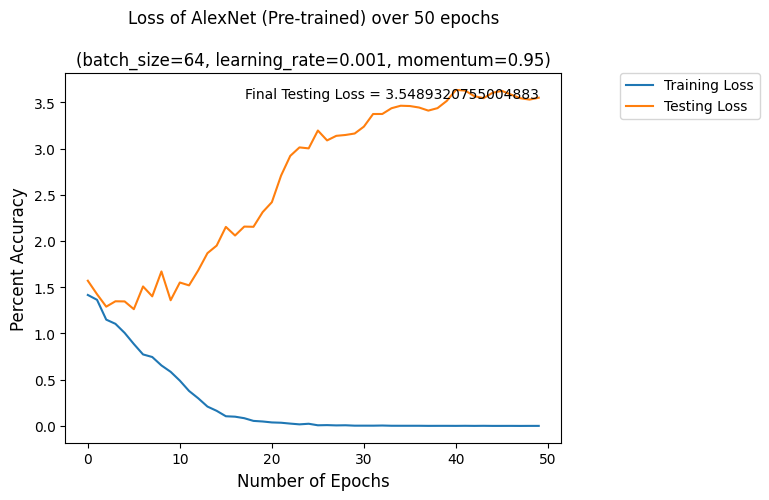

In [114]:
# plot_param = "Accuracy"
plot_param = "Loss"

model_type = "AlexNet"

epochs = [i for i in range(50)]

# with open(fname, 'rb') as f: 
#     output = pk.load(f)

hyperparams = f"(batch_size={batch_size}, learning_rate={lr}, momentum={momentum})"

plt.figure()

# if plot_param == "accuracy":
# plt.title(f"Accuracy of {model_type} (Pre-trained) over 50 epochs\n\n" + hyperparams)
# plt.plot(epochs, output["train_accs"][50:], label = "Training Accuracy")
# plt.plot(epochs, output["test_accs"][50:], label = "Testing Accuracy")


# if plot_param == "loss":
plt.title(f"Loss of {model_type} (Pre-trained) over 50 epochs\n\n" + hyperparams)
plt.plot(epochs, output["train_losses"][50:], label = "Training Loss")
plt.plot(epochs, output["test_losses"][50:], label = "Testing Loss")


plt.ylabel("Percent Accuracy", size=12)
plt.xlabel("Number of Epochs", size=12)
plt.legend(bbox_to_anchor=(1.4, 1), loc='upper right', borderaxespad=0)
final_dp = output["test_losses"][99]
plt.text(epochs[-1], final_dp, f"Final Testing {plot_param} = {final_dp}", horizontalalignment='right')
plt.show()

In [ ]:
train_loss, train_acc, test_loss, test_acc = [], [], [], []

model.to(device)

print("Start training")
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
      images, labels = images.to(device), labels.to(device)
      optimizer.zero_grad()
      outputs = model(images)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()

    training_loss = running_loss / len(train_loader)
    print(f'Epoch {epoch + 1}, Loss: {training_loss}', end='  |  ')
    train_loss.append(training_loss)

    model.eval()

    correct = 0
    total = 0
    with torch.no_grad():
      for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Train Accuracy: {accuracy:.2f}%', end='  |  ')
    train_acc.append(accuracy)

    correct = 0
    total = 0
    running_testing_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_testing_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')
    test_acc.append(accuracy)
    test_loss.append(running_testing_loss)

torch.save(model.state_dict(), 'alexnet.ckpt')